In [1]:
# =====================================================
# Model Training & Evaluation: Student Performance Predictor
# Name: Abdulaziz Aloufi
# Student ID: C00266252
# =====================================================

# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Set a consistent style for plots
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

In [4]:
# --- 2. Load and Preprocess the Dataset ---

# Load the UCI student performance dataset 
df = pd.read_csv("../data/student-mat.csv", sep=';')

# Create a binary target variable:
# 1 = pass (G3 >= 10), 0 = fail (G3 < 10)
df['pass_fail'] = np.where(df['G3'] >= 10, 1, 0)

# Drop the original grade columns to avoid data leakage
df = df.drop(columns=['G1', 'G2', 'G3'])

# Identify categorical columns (object type) for encoding
cat_cols = df.select_dtypes(include=['object']).columns

# Apply label encoding to each categorical feature
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Quick preview of the processed dataframe 
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,pass_fail
0,0,0,18,1,0,0,4,4,0,4,...,0,0,4,3,4,1,1,3,6,0
1,0,0,17,1,0,1,1,1,0,2,...,1,0,5,3,3,1,1,3,4,0
2,0,0,15,1,1,1,1,1,0,2,...,1,0,4,3,2,2,3,3,10,1
3,0,0,15,1,0,1,4,2,1,3,...,1,1,3,2,2,1,1,5,2,1
4,0,0,16,1,0,1,3,3,2,2,...,0,0,4,3,2,1,2,5,4,1


In [5]:
# --- 3. Train/Test Split ---

# Define features (X) and target (y)
x = df.drop('pass_fail', axis=1)
y = df['pass_fail']

# Split into training and test sets (80/20 split), stratified by target
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Display shapes for sanity check
x_train.shape, x_test.shape

((316, 30), (79, 30))

In [ ]:
# --- 4. Train Models ---

# 4.1 Logistic Regression (baseline linear model)
log_model = LogisticRegression(max_iter=2000)
log_model.fit(x_train, y_train)
log_pred = log_model.predict(x_test)

# 4.2 Random Forest (ensemble of decision trees)
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)

# 4.3 Decision Tree (single tree with limited depth to reduce overfitting)
dt_model = DecisionTreeClassifier(max_depth=6, random_state=42)
dt_model.fit(x_train, y_train)
dt_pred = dt_model.predict(x_test)

In [6]:
def evaluate_model(name, y_test, predictions):
    acc = accuracy_score(y_test, predictions)
    prec = precision_score(y_test, predictions)
    rec = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    return [name, acc, prec, rec, f1]

results = []
results.append(evaluate_model("Logistic Regression", y_test, log_pred))
results.append(evaluate_model("Random Forest", y_test, rf_pred))
results.append(evaluate_model("Decision Tree", y_test, dt_pred))
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])


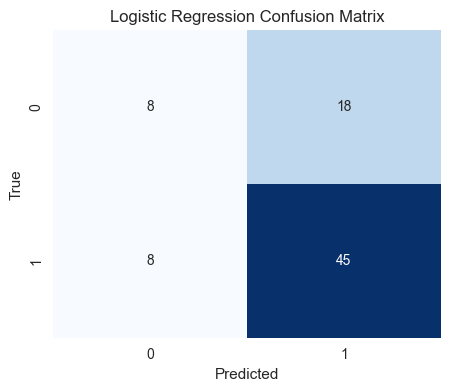

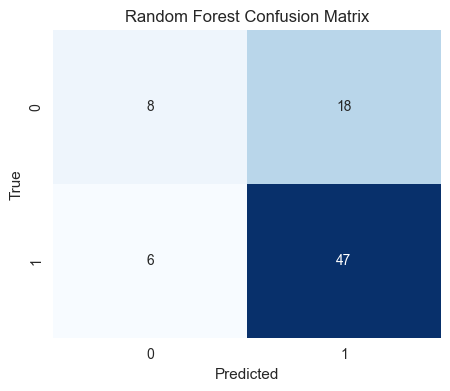

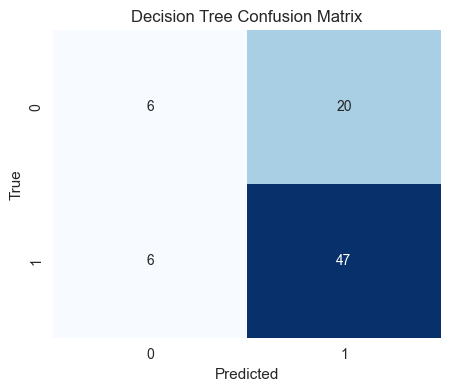

In [8]:
models = {
    "Logistic Regression": log_pred,
    "Random Forest": rf_pred,
    "Decision Tree": dt_pred
}

for name, pred in models.items():
    cm = confusion_matrix(y_test, pred, labels=[0,1])  # <-- FIX
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


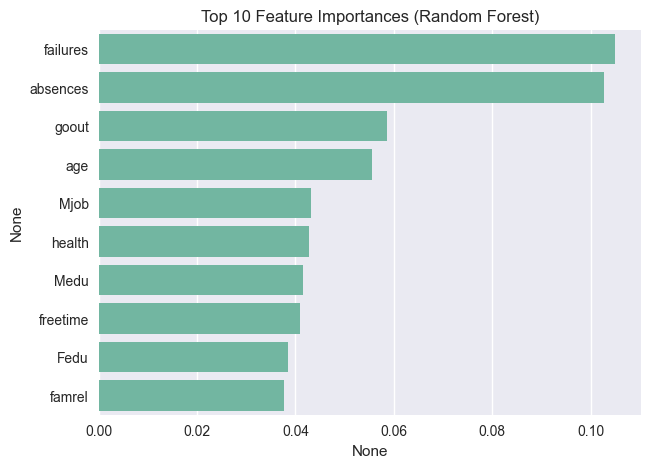

In [9]:
importamces = pd.Series(rf_model.feature_importances_, index=x.columns)
importamces.sort_values(ascending=False).head(10)

plt.figure(figsize=(7,5))
sns.barplot(x=importamces.sort_values(ascending=False).head(10), y=importamces.sort_values(ascending=False).head(10).index)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()


In [10]:
import joblib

joblib.dump(rf_model, "../models/best_model.pkl")

print("Model saved to ../models/best_model.pkl")



Model saved to ../models/best_model.pkl


In [11]:
import joblib

model = joblib.load("../models/best_model.pkl")
print(model)



RandomForestClassifier(n_estimators=300, random_state=42)


In [12]:
model.feature_importances_


array([0.00877225, 0.01868842, 0.05558945, 0.01607079, 0.01672334,
       0.00868329, 0.0414715 , 0.03848317, 0.04310352, 0.03565169,
       0.0344191 , 0.02948793, 0.0235153 , 0.03471335, 0.10500271,
       0.02504631, 0.01787328, 0.01855125, 0.01971664, 0.01645282,
       0.01573896, 0.01073418, 0.01902314, 0.03764714, 0.04082229,
       0.05866568, 0.02646037, 0.03749204, 0.04266486, 0.10273523])

In [13]:
model.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}